# Certified Randomness Amplification
## Dynamically Probing Remote Random Quantum States

This notebook implements a protocol to generate high-quality random numbers using a quantum computer, based on the paper [Certified randomness amplification by dynamically probing remote random quantum states, (arXiv:2511.03686)](https://arxiv.org/abs/2511.03686), Liu et al, 2025.

### Protocol Overview

The protocol ensures that the randomness generated by a remote quantum device is genuine and not produced by a classical simulation or a pre-determined sequence. It relies on the computational hardness of simulating random quantum circuits.

The key steps are:

1.  **Challenge Generation**: The client generates a random quantum circuit. The circuit consists of layers of random single-qubit gates and fixed two-qubit entangling gates.
2.  **Gate Streaming & Delayed Measurement**: The client streams the single-qubit gates to the server. Crucially, the measurement basis for the final layer is revealed only at the very last moment. This minimizes the time available for a malicious server to perform a classical simulation (spoofing).
3.  **Sampling**: The quantum server executes the circuit and returns a bitstring sample within a strict time window.
4.  **Verification**: The client verifies the randomness by computing the **Linear Cross-Entropy Benchmarking (XEB)** score. A high XEB score certifies that the samples were likely generated by a quantum process and are therefore unpredictable.
5.  **Amplification (Conceptual)**: In the full protocol, the certified quantum randomness is combined with a weak random source using a randomness extractor to produce nearly perfect randomness.

### Circuit Structure
The circuits used in this protocol are constructed as follows:
-   **Initial State**: $|0\rangle^{\otimes n}$
-   **Layers**: Alternating layers of random single-qubit gates and fixed two-qubit gates (Rzz).
-   **Single-Qubit Gates**: Drawn from the set $\{ Z^p X^{1/2} Z^{-p} \}$ where $p \in \{-1, -3/4, \dots, 3/4\}$.
-   **Final Layer**: A final layer of single-qubit gates followed by measurement in a basis determined by the client.

In [78]:
import qsharp
import numpy as np
import matplotlib.pyplot as plt

In [79]:
QSHARP_SOURCE = """
import Std.Math.*;
import Std.Arrays.*;
import Std.Diagnostics.*;
import Std.Measurement.*;

/// <summary>
/// Applies the single-qubit gate used in the protocol: Z^p * X^(1/2) * Z^-p.
/// </summary>
operation RandomSQGate(q : Qubit, p : Double) : Unit {
    // p corresponds to angles p * pi
    let angle = p * PI();
    
    // Z^-p
    Rz(-angle, q);
    // X^1/2 (pi/2 rotation)
    Rx(PI() / 2.0, q);
    // Z^p
    Rz(angle, q);
}

/// <summary>
/// Applies the Random Circuit layers to the qubits.
/// Does NOT measure.
/// </summary>
operation ApplyRandomCircuit(qubits : Qubit[], depth : Int, parameters : Double[], entanglingPairs : Int[]) : Unit {
    let nQubits = Length(qubits);
    let nPairsPerLayer = nQubits / 2;
    
    for d in 0..depth-1 {
        // 1. Layer of Random Single-Qubit Gates
        for q in 0..nQubits-1 {
            let paramIndex = d * nQubits + q;
            let p = parameters[paramIndex];
            RandomSQGate(qubits[q], p);
        }
        
        // 2. Layer of Entangling Gates (Rzz)
        for i in 0..nPairsPerLayer-1 {
            let baseIdx = (d * nPairsPerLayer + i) * 2;
            let q1 = entanglingPairs[baseIdx];
            let q2 = entanglingPairs[baseIdx + 1];
            
            Rzz(PI() / 2.0, qubits[q1], qubits[q2]);
        }
    }
    
    // 3. Final Layer (Dynamic Basis)
    let finalLayerStart = depth * nQubits;
    for q in 0..nQubits-1 {
        let p = parameters[finalLayerStart + q];
        RandomSQGate(qubits[q], p);
    }
}

/// <summary>
/// Runs the random circuit sampling protocol and returns measurement results.
/// </summary>
operation RunRandomCircuit(nQubits : Int, depth : Int, parameters : Double[], entanglingPairs : Int[]) : Result[] {
    use qubits = Qubit[nQubits];
    
    ApplyRandomCircuit(qubits, depth, parameters, entanglingPairs);
    
    // Measure and return results
    let results = MeasureEachZ(qubits);
    ResetAll(qubits);
    return results;
}
"""

In [80]:
def generate_circuit_data(num_qubits, depth, seed=None):
    """
    Generates the parameters and entangling pairs for the random circuit.
    
    The circuit consists of:
    1. Layers of random single-qubit gates.
    2. Layers of entangling gates (Rzz) between random pairs.
    3. A final layer of random single-qubit gates.
    
    Returns:
        - parameters: List of 'p' values for the single-qubit gates Z^p X^1/2 Z^-p.
        - entangling_pairs: List of qubit indices for the two-qubit gates.
    """
    rng = np.random.default_rng(seed)
    
    # Possible values for p as defined in the paper methods
    # p in {-1, -3/4, -1/2, ..., 3/4}
    p_values = np.linspace(-1, 0.75, 8)
    
    parameters = []
    entangling_pairs = []
    
    for d in range(depth):
        # 1. Layer of Random Single-Qubit Gates
        for q in range(num_qubits):
            p = rng.choice(p_values)
            parameters.append(float(p))
            
        # 2. Layer of Entangling Gates (Random Pairs)
        # Generate a random perfect matching
        qubits = np.arange(num_qubits)
        rng.shuffle(qubits)
        
        # Pair them up: (0,1), (2,3), etc.
        for i in range(0, num_qubits, 2):
            q1, q2 = int(qubits[i]), int(qubits[i+1])
            entangling_pairs.extend([q1, q2])
            
    # 3. Final Layer
    for q in range(num_qubits):
        p = rng.choice(p_values)
        parameters.append(float(p))
        
    return parameters, entangling_pairs

## 2. Ideal Simulation

To verify the output of the quantum computer, we need to compare the sampled bitstrings against the ideal probability distribution of the circuit. 

In a real-world scenario with many qubits (e.g., > 50), calculating the full probability distribution is intractable. Instead, one would compute the probability of *only* the observed bitstrings using tensor network contraction methods.

For this demonstration with a small number of qubits, we can use a state vector simulator to compute the full probability distribution $|\psi|^2$.

In [81]:
def get_ideal_probabilities_qsharp(n_qubits, depth, parameters, entangling_pairs):
    """
    Uses Q# simulator to calculate the ideal state vector and probabilities.
    """
    # Reset simulator to ensure clean state (no accumulated qubits)
    qsharp.init()
    
    # Re-evaluate the Q# source code because init() cleared it
    qsharp.eval(QSHARP_SOURCE)
    
    qsharp.eval(f"use qs = Qubit[{n_qubits}];")
    qsharp.eval(f"ApplyRandomCircuit(qs, {depth}, {parameters}, {entangling_pairs});")
    
    dump = qsharp.dump_machine()
    qsharp.eval("ResetAll(qs);")
    
    # Extract probabilities from the dump
    amplitudes = dump.as_dense_state()
    probs = [abs(z)**2 for z in amplitudes]
    
    # Verify size
    expected_len = 2**n_qubits
    if len(probs) != expected_len:
        print(f"Warning: Dump size {len(probs)} does not match expected 2^{n_qubits}={expected_len}.")
    
    return probs

## 3. Utilities

Helper functions to process the results from the quantum simulator.

In [82]:
def result_array_to_bitstring(result_array):
    """
    Converts Q# Result[] to a bitstring.
    Matches Q# DumpMachine endianness (Big Endian: q0 is MSB).
    """
    def map_res(r):
        s = str(r)
        if s == "One" or s == "1" or r == 1: return "1"
        return "0"
    
    # result_array is [q0, q1, ...]. 
    # We want string "q0q1..." so that int(s, 2) corresponds to q0*2^{n-1} + ...
    # So we do NOT reverse.
    return "".join(map_res(x) for x in result_array)

## 4. Certification (XEB)

The core of the protocol is the **Linear Cross-Entropy Benchmarking (XEB)** score. This score quantifies how well the experimental samples correlate with the ideal quantum distribution.

The XEB score is defined as:
$$ \text{XEB} = 2^n \langle P(x_i) \rangle - 1 $$
where:
- $n$ is the number of qubits.
- $x_i$ are the sampled bitstrings.
- $P(x_i)$ is the ideal probability of observing bitstring $x_i$ (computed via simulation).
- $\langle \cdot \rangle$ denotes the average over the samples.

**Interpretation:**
- **XEB $\approx$ 1**: Indicates the device is sampling from the ideal quantum distribution (high fidelity).
- **XEB $\approx$ 0**: Indicates the device is outputting uniform random noise or classical spoofing (no quantum advantage).
- **XEB > Threshold**: In the paper, a threshold (e.g., > 0.002 for large circuits) is used to certify randomness. For small circuits, we expect values close to 1.

In [83]:
def calculate_xeb(sampled_bitstrings, ideal_probs):
    """
    Calculates Linear Cross-Entropy Benchmarking (XEB) score.
    """
    # Calculate N based on the bitstring length, which reflects the actual number of measured qubits
    if not sampled_bitstrings:
        return 0.0
        
    n_qubits = len(sampled_bitstrings[0])
    N = 2**n_qubits
    
    observed_probs = []
    for b in sampled_bitstrings:
        # Convert bitstring to integer index
        # We assume bitstring matches dump_machine endianness (Big Endian: q0 is MSB)
        idx = int(b, 2)
        if idx < len(ideal_probs):
            observed_probs.append(ideal_probs[idx])
        else:
            # Fallback or error
            pass
        
    mean_prob = np.mean(observed_probs)
    xeb_score = (N * mean_prob) - 1
    return xeb_score

def calculate_theoretical_xeb(ideal_probs):
    """
    Calculates the theoretical expected XEB score for this specific circuit instance.
    Expected XEB = N * sum(p^2) - 1
    """
    N = len(ideal_probs)
    sum_sq = sum(p**2 for p in ideal_probs)
    return (N * sum_sq) - 1

## 5. Running the Protocol

We will now run the full protocol with a small number of qubits ($N=4$) to demonstrate the process. In a real deployment, $N$ would be much larger (e.g., 50-100) to ensure classical intractability.

In [84]:
# --- Simulation Parameters ---
n_qubits = 4
depth = 8
shots = 10000

print(f"Running Certified Randomness Protocol with {n_qubits} qubits, depth {depth}...")

Running Certified Randomness Protocol with 4 qubits, depth 8...


### Step 1: Generate Challenge
We generate the random circuit parameters (single-qubit gate angles) and the entangling pairs. This represents the "challenge" sent to the quantum computer.

In [85]:
# 1. Generate Challenge (Parameters)
parameters, entangling_pairs = generate_circuit_data(n_qubits, depth, seed=42)
print("Challenge circuit generated.")

Challenge circuit generated.


### Step 2: Ideal Simulation
We compute the ideal probability distribution $|\psi|^2$ using a state vector simulator. This serves as the ground truth for verification.

In [86]:
# 2. Simulate "Ideal" Quantum Computer (Q# Simulator)
print("Calculating ideal probabilities using Q# simulator...")
# This will reset the Q# environment and re-load the Q# code
ideal_probs = get_ideal_probabilities_qsharp(n_qubits, depth, parameters, entangling_pairs)
print("Ideal probabilities calculated.")

Calculating ideal probabilities using Q# simulator...
Ideal probabilities calculated.


### Step 3: Execution (Sampling)
We simulate the "real" execution of the quantum computer. In this demo, we use the same Q# simulator to generate samples, but in a real scenario, this would be a physical device. The key is that we collect *samples* (bitstrings), not probabilities.

In [87]:
# 3. Simulate "Real" Execution (Q# Sampling)
print(f"Executing on Q# simulator ({shots} shots)...")

# Re-import RunRandomCircuit because qsharp.init() inside get_ideal_probabilities_qsharp
# invalidated the previous import.
from qsharp.code import RunRandomCircuit 

sampled_bitstrings = []

for _ in range(shots):
    result = RunRandomCircuit(n_qubits, depth, parameters, entangling_pairs)
    bitstring = result_array_to_bitstring(result)
    sampled_bitstrings.append(bitstring)
    
print(f"Collected {len(sampled_bitstrings)} samples.")

Executing on Q# simulator (10000 shots)...
Collected 10000 samples.


### Step 4: Analysis
We calculate the XEB score to certify the randomness. We also visualize the distribution of sampled bitstrings. A "spiky" distribution (Porter-Thomas) is characteristic of random quantum circuits, whereas a uniform distribution would indicate classical noise or spoofing.

--------------------------------------------------
XEB Score: 1.2593
Theoretical Expected XEB (Infinite Shots): 1.2743
--------------------------------------------------
Interpretation:
1. XEB Score:
   - ~1.0: Ideal Quantum Behavior (Perfect Fidelity) for large random circuits.
   - ~0.0: Classical Randomness / Noise (Spoofing).
   - > 0.1: Strong evidence of quantum interference.
   - Your score (1.2593) indicates successful quantum certification.
   - Note: For small systems (N=4) and specific circuit instances, scores > 1.0 are normal.
     The score may exceed the theoretical expectation (1.2743) due to finite sampling noise (10000 shots).

2. Histogram Shape:
   - Quantum: 'Spiky' (Porter-Thomas distribution). Some outcomes are very frequent, others rare.
   - Classical: Flat/Uniform. All outcomes appear with roughly equal frequency.

>>> SUCCESS: Randomness is certified quantum! <<<


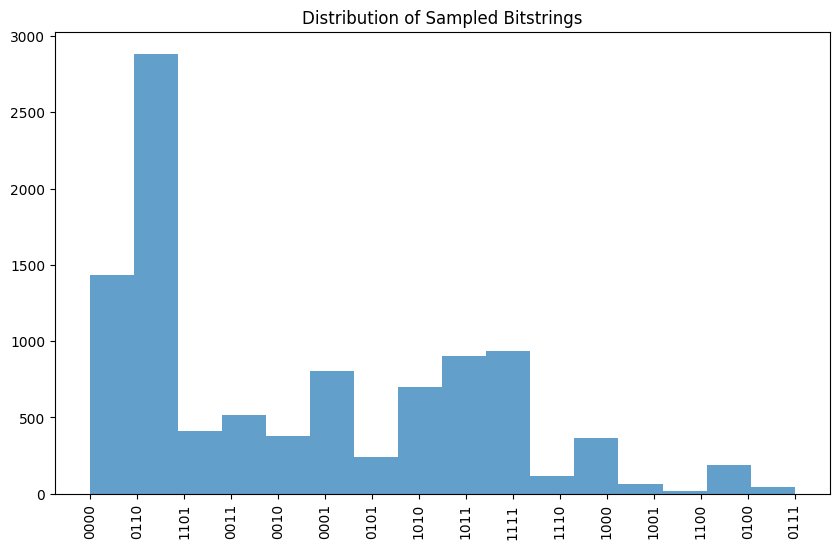

In [88]:
# 4. Certification (XEB Calculation)
score = calculate_xeb(sampled_bitstrings, ideal_probs)
theoretical_score = calculate_theoretical_xeb(ideal_probs)

print("-" * 50)
print(f"XEB Score: {score:.4f}")
print(f"Theoretical Expected XEB (Infinite Shots): {theoretical_score:.4f}")
print("-" * 50)

print("Interpretation:")
print("1. XEB Score:")
print("   - ~1.0: Ideal Quantum Behavior (Perfect Fidelity) for large random circuits.")
print("   - ~0.0: Classical Randomness / Noise (Spoofing).")
print("   - > 0.1: Strong evidence of quantum interference.")
print(f"   - Your score ({score:.4f}) indicates {('successful quantum certification' if score > 0.1 else 'potential noise or spoofing')}.")
print("   - Note: For small systems (N=4) and specific circuit instances, scores > 1.0 are normal.")
print(f"     The score may exceed the theoretical expectation ({theoretical_score:.4f}) due to finite sampling noise ({shots} shots).")

print("\n2. Histogram Shape:")
print("   - Quantum: 'Spiky' (Porter-Thomas distribution). Some outcomes are very frequent, others rare.")
print("   - Classical: Flat/Uniform. All outcomes appear with roughly equal frequency.")

if score > 0.1:
    print("\n>>> SUCCESS: Randomness is certified quantum! <<<")
else:
    print("\n>>> FAIL: Output looks like classical noise/spoofing. <<<")

# Visualization
plt.figure(figsize=(10, 6))
plt.hist(sampled_bitstrings, bins=len(set(sampled_bitstrings)), alpha=0.7, label='Sampled')
plt.title("Distribution of Sampled Bitstrings")
plt.xticks(rotation=90)
plt.show()

## 6. Next Steps: Randomness Amplification

In the full protocol described in the paper, the certified randomness obtained above is not the final output. It serves as a high-quality seed.

1.  **Seed Extraction**: The certified samples are combined with a weak random source using a **Two-Source Extractor**. This produces a nearly perfect random seed.
2.  **Amplification**: This seed is then used with a **Seeded Extractor** to extract a large amount of randomness from the weak source.

This two-step process allows for **Certified Randomness Amplification**, turning a weak, potentially biased source into a strong, certified random source using the quantum computer as a catalyst.